In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
#infile = '../test7/ntuple_SingleMuon_Toy3_2GeV.0.root'
infile = '../test7/ntuple_SingleMuon_Toy3_3GeV.0.root'
#infile = '../test7/ntuple_SingleMuon_Toy3_4GeV.0.root'
#infile = '../test7/ntuple_SingleMuon_Toy3_5GeV.0.root'

infile_r = root_open(infile)
tree = infile_r.ntupler.tree
ttstub_tree = infile_r.ttstubntupler.tree

tree.define_collection(name='hits', prefix='vh_', size='vh_size')
tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
tree.define_collection(name='particles', prefix='vp_', size='vp_size')

ttstub_tree.define_collection(name='hits', prefix='vh_', size='vh_size')

In [4]:
hits_phi = [np.pi/4] * 10
hits_r = [0.] * 10
hits_z = [0.] * 10

for ievt, (evt1, evt2) in enumerate(zip(tree, ttstub_tree)):
  print("evt {0}".format(ievt))
  
  # EMTF hits
  for ihit, hit in enumerate(evt1.hits):
    print(".. hit {0} {1} {2} {3}".format(ihit, np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z))
    phi, r, z = np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z
    hits_phi.append(phi)
    hits_r.append(r)
    hits_z.append(z)

  # TT hits
  for ihit, hit in enumerate(evt2.hits):
    print(".. hit {0} {1} {2} {3}".format(ihit + len(evt1.hits), np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z))
    phi, r, z = np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z
    hits_phi.append(phi)
    hits_r.append(r)
    hits_z.append(z)
    
hits_phi = np.asarray(hits_phi)
hits_r = np.asarray(hits_r)
hits_z = np.asarray(hits_z)

idx = np.argsort(hits_r)
hits_phi = hits_phi[idx]
hits_r = hits_r[idx]
hits_z = hits_z[idx]

hits_phi = hits_phi - np.pi/4

evt 0
.. hit 0 1.10954068758 182.108413696 567.971252441
.. hit 1 1.23596320821 241.910018921 793.598754883
.. hit 2 1.23923077371 254.459457397 815.05871582
.. hit 3 1.24624061317 294.153991699 948.785522461
.. hit 4 1.24494152319 305.864685059 968.900024414
.. hit 5 1.23928749904 320.164520264 1038.4519043
.. hit 6 1.23596320821 241.910018921 793.598754883
.. hit 7 1.23923077371 254.459457397 815.05871582
.. hit 8 1.24624061317 294.153991699 948.785522461
.. hit 9 1.24494152319 305.864685059 968.900024414
.. hit 10 1.23928749904 320.164520264 1038.4519043
.. hit 11 0.860693051107 40.247756958 133.207000732
.. hit 12 0.874787231965 47.7764015198 157.026992798
.. hit 13 0.891002886947 56.5573616028 184.397003174
.. hit 14 0.913638557791 65.2692718506 219.479003906
.. hit 15 0.913638557791 70.2428512573 220.789001465
.. hit 16 0.939926221437 80.7147979736 267.140014648
.. hit 17 0.938392573544 83.9957275391 264.170013428
.. hit 18 0.832166268195 24.9460906982 85.2337417603
.. hit 19 0.8

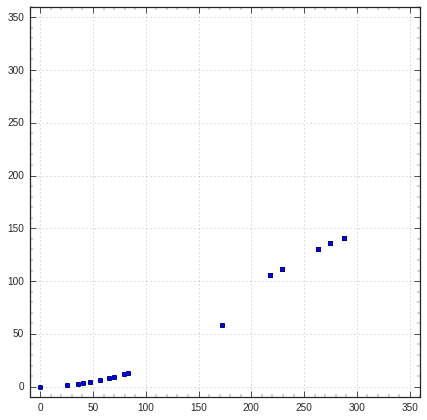

In [5]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(hits_r*np.cos(hits_phi), hits_r*np.sin(hits_phi))
ax.set_xlim(-10,360)
ax.set_ylim(-10,360)
plt.show()

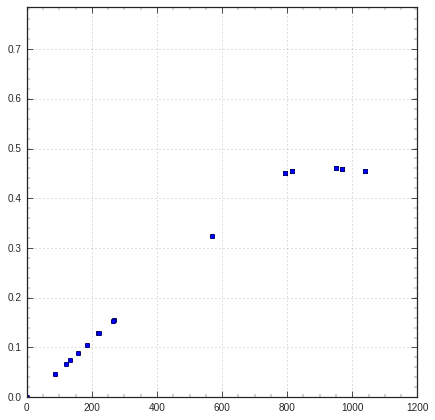

In [6]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(hits_z, hits_phi)
ax.set_xlim(0,1200)
ax.set_ylim(0,np.pi/4)
plt.show()

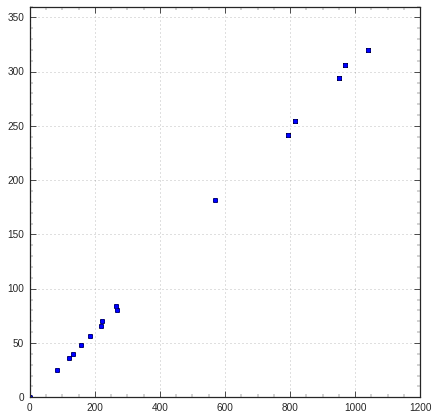

In [7]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(hits_z, hits_r)
ax.set_xlim(0,1200)
ax.set_ylim(0,360)
plt.show()

### Interpolation

In [8]:
lins_z = np.linspace(0,1080,num=101)

print hits_z.shape, np.max(hits_z)

(410,) 1038.451904296875


In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-2, 1e2)) * RBF(360, (1e-1, 1e5))
alpha = 0.01
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gp.fit(np.atleast_2d(hits_z).T, hits_phi)
print kernel.get_params()
print gp.kernel_.get_params()

{'k1__constant_value': 1.0, 'k2__length_scale': 360, 'k2': RBF(length_scale=360), 'k1': 1**2, 'k1__constant_value_bounds': (0.01, 100.0), 'k2__length_scale_bounds': (0.1, 100000.0)}
{'k1__constant_value': 0.08239149765900056, 'k2__length_scale': 717.8388089995502, 'k2': RBF(length_scale=718), 'k1': 0.287**2, 'k1__constant_value_bounds': (0.01, 100.0), 'k2__length_scale_bounds': (0.1, 100000.0)}


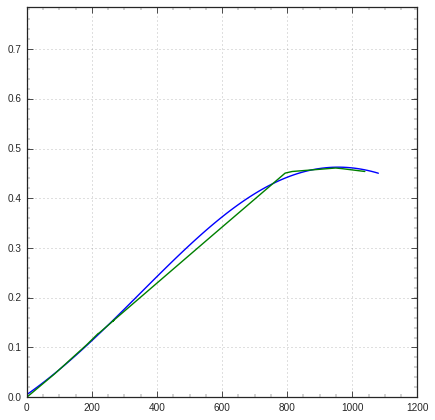

In [10]:
lins_phi, sigma = gp.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(lins_z, lins_phi)
ax.plot(hits_z, hits_phi)
ax.set_xlim(0,1200)
ax.set_ylim(0,np.pi/4)
plt.show()

In [11]:
kernel = C(100.0, (1e-2, 1e5)) * RBF(360, (1e-1, 1e5))
alpha = 0.01 * 20000
gpx = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gpx.fit(np.atleast_2d(hits_z).T, hits_r * np.cos(hits_phi))
print kernel.get_params()
print gpx.kernel_.get_params()

{'k1__constant_value': 100.0, 'k2__length_scale': 360, 'k2': RBF(length_scale=360), 'k1': 10**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}
{'k1__constant_value': 31482.176626884007, 'k2__length_scale': 534.4110934598081, 'k2': RBF(length_scale=534), 'k1': 177**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}


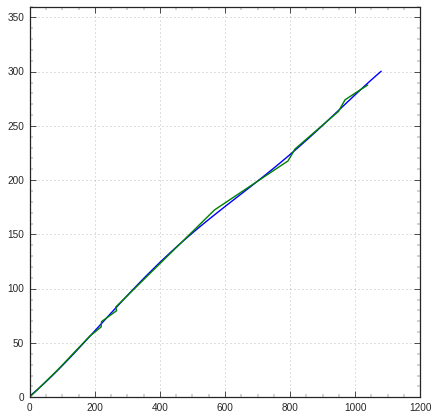

In [12]:
lins_x, sigma = gpx.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(lins_z, lins_x)
ax.plot(hits_z, hits_r * np.cos(hits_phi))
ax.set_xlim(0,1200)
ax.set_ylim(0,360)
plt.show()

In [13]:
gpy = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gpy.fit(np.atleast_2d(hits_z).T, hits_r * np.sin(hits_phi))
print kernel.get_params()
print gpy.kernel_.get_params()

{'k1__constant_value': 100.0, 'k2__length_scale': 360, 'k2': RBF(length_scale=360), 'k1': 10**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}
{'k1__constant_value': 6928.418069167537, 'k2__length_scale': 641.1526036036595, 'k2': RBF(length_scale=641), 'k1': 83.2**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}


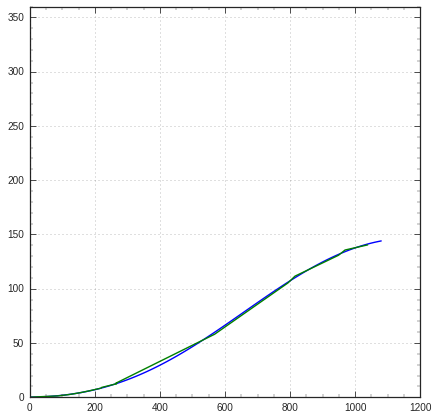

In [14]:
lins_y, sigma = gpy.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(lins_z, lins_y)
ax.plot(hits_z, hits_r * np.sin(hits_phi))
ax.set_xlim(0,1200)
ax.set_ylim(0,360)
plt.show()

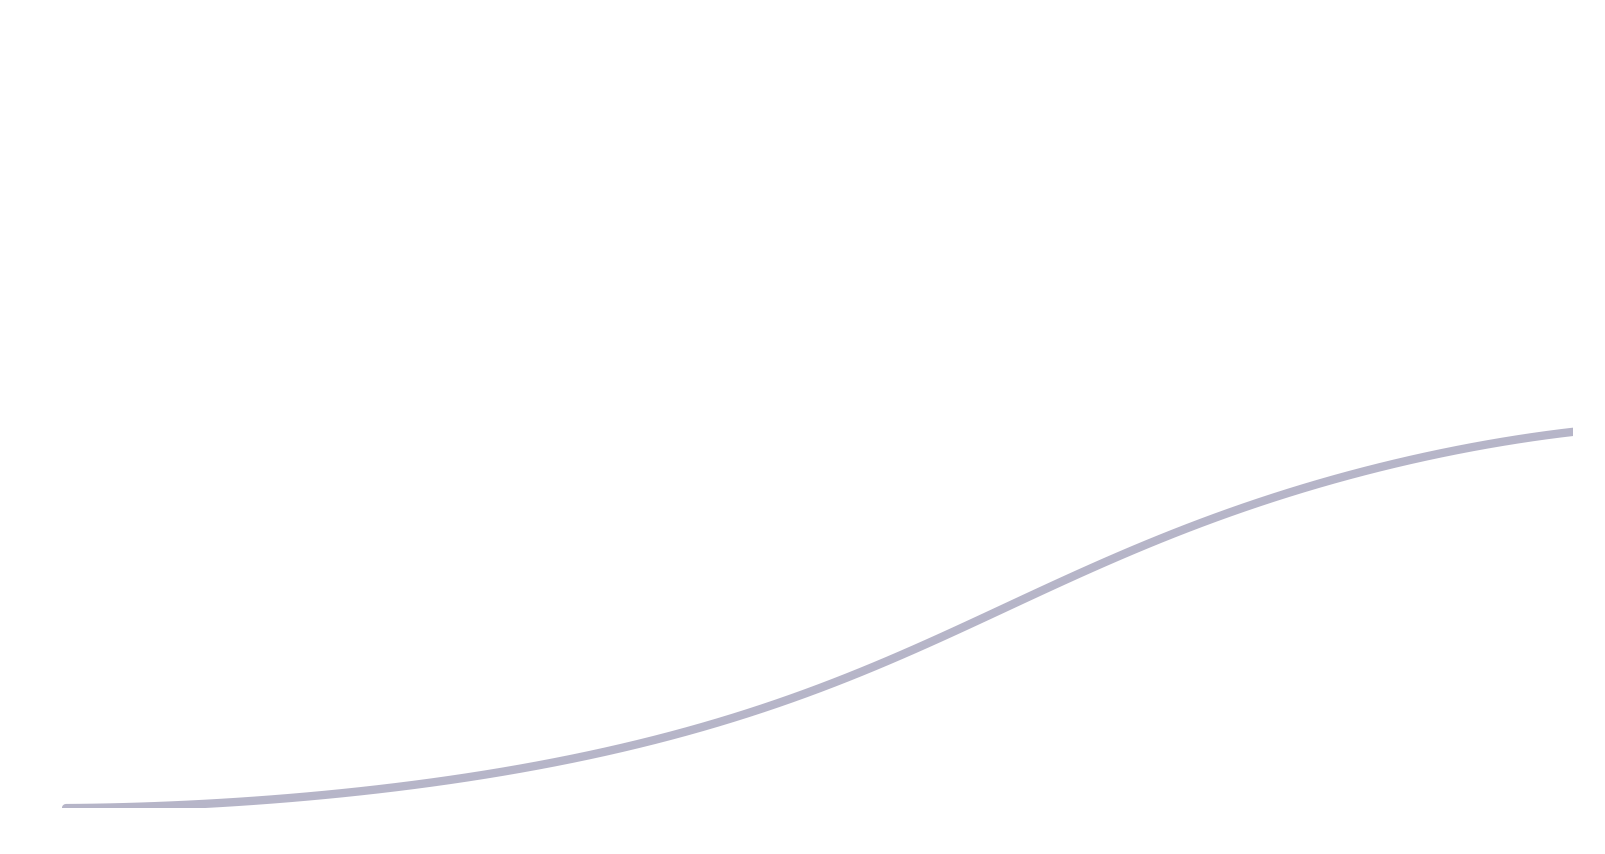

In [15]:
with plt.rc_context({"figure.dpi": 150}):
  fig, ax = plt.subplots(figsize=(12+1,6.75))
  ax.plot(lins_x, lins_y, c='#302b63', lw=4, alpha=0.35)
  ax.set_xlim(0,300)
  ax.set_ylim(0,300)
  ax.axis('off')
  plt.show()